## Analysis of Sales data

### Dataset

The given dataset contains monthly total sales of a company for the period 2013-2016.

### Objectives

1. To analyse the sales data and understand the performance of the company.
2. Find patterns and construct a model to forecast future sales.


### Load sales data and create visualization

In [1]:
from time_series import TimeSeries

# Imports for data visualization
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld

register_matplotlib_converters()



Sales Data
               sales
count      48.000000
mean    47858.351667
std     25221.124187
min      4519.890000
25%     29790.100000
50%     39339.515000
75%     65833.345000
max    118447.830000
Head and Tail of the time series
date
2013-01-01    14236.90
2013-02-01     4519.89
2013-03-01    55691.01
2013-04-01    28295.35
2013-05-01    23648.29
Name: sales, dtype: float64
date
2016-08-01     63120.89
2016-09-01     87866.65
2016-10-01     77776.92
2016-11-01    118447.83
2016-12-01     83829.32
Name: sales, dtype: float64


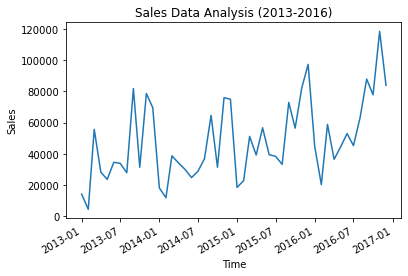

In [2]:
ts = TimeSeries('dataset/monthly_sales.csv', train_size=0.8)

print("Sales Data")
print(ts.data.describe())

print("Head and Tail of the time series")
print(ts.data.head(5).iloc[:,1])
print(ts.data.tail(5).iloc[:,1])

# Plot of raw time series data
plt.plot(ts.data.index,ts.data.sales)
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

### Seasonal Decompose of the time series

Seasonal decompose is a method used to decompose the components of a time series into the following:
- Level - average value in the series.
- Trend - increasing or decreasing value in the series.
- Seasonality - repeating short-term cycle in the series.
- Noise - random variation in the series.

The analysis of the components individually provide better insights for model selection.

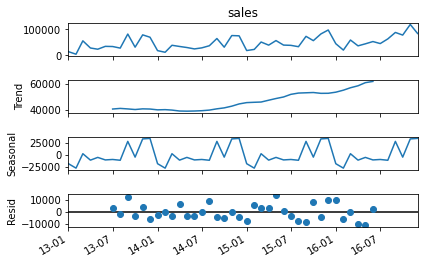

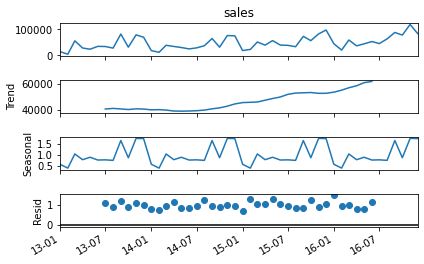

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(ts.data.iloc[:,1],period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(ts.data.iloc[:,1],period=12,model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()


### Observations from Seasonal Decompose

1. The time series seems to roughly have a constant seasonality but has an overall **increasing trend**.
2. A slightly decreasing trend is observed till 2014-07 after that an increasing trend is observed.

### Model Selection

From the above observations we can evidently conclude that **Holt-Winter additive model** would be an appropriate choice as there is a constant seasonality component along with an increasing trend.


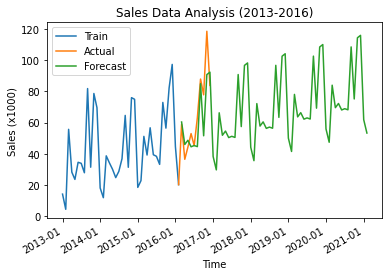

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Scaling down the data by a factor of 1000
ts.set_scale(1000)

# Training the model
model = ExponentialSmoothing(ts.train,trend='additive',seasonal='additive',seasonal_periods=12).fit(damping_slope=1)
plt.plot(ts.train.index,ts.train,label="Train")
plt.plot(ts.test.index,ts.test,label="Actual")

# Create a 5 year forecast
plt.plot(model.forecast(60),label="Forecast")

plt.legend(['Train','Actual','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales (x1000)")
plt.show()

### Validation of the model
Let's do a brief comparison between the additive and the multiplicative models.

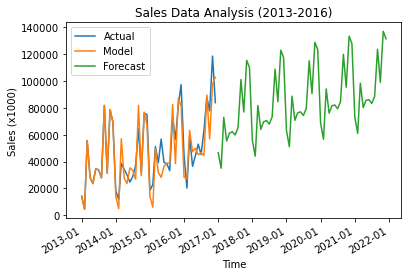

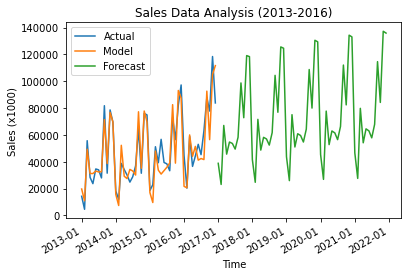

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ts = TimeSeries('dataset/monthly_sales.csv', train_size=0.8)
# Additive model
model_add = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='additive',seasonal_periods=12,damped=True).fit(damping_slope=0.98)
prediction = model_add.predict(start=ts.data.iloc[:,1].index[0],end=ts.data.iloc[:,1].index[-1])
plt.plot(ts.data.iloc[:,1].index,ts.data.iloc[:,1],label="Train")
plt.plot(ts.data.iloc[:,1].index,prediction,label="Model")
plt.plot(model_add.forecast(60))

plt.legend(['Actual','Model','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales (x1000)")
plt.show()


# Multiplicative model
model_mul = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='multiplicative',seasonal_periods=12,damped=True).fit()
prediction = model_mul.predict(start=ts.data.iloc[:,1].index[0],end=ts.data.iloc[:,1].index[-1])
plt.plot(ts.data.iloc[:,1].index,ts.data.iloc[:,1],label="Train")
plt.plot(ts.data.iloc[:,1].index,prediction,label="Model")
plt.plot(model_mul.forecast(60))
plt.legend(['Actual','Model','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales (x1000)")
plt.show()

In [14]:
print(model_add.summary())
print(model_mul.summary())

ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                     5088109579.122
Optimized:                         True   AIC                            920.991
Trend:                         Additive   BIC                            952.801
Seasonal:                      Additive   AICC                           948.133
Seasonal Periods:                    12   Date:                 Fri, 27 Mar 2020
Box-Cox:                          False   Time:                         14:52:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1052632                alpha                 True
smoothing_slope               0.1052632         

### Conclusion of the analysis

From the model summary obtained it is clear that the sum of squared errors (SSE) for the additive model (5088109579.122) < the SSE for the multiplicative(5235252441.242) model.

Hence the initial assumption that seasonality is roughly constant and therefore choosing additive model was appropriate. 

Note:
The forecast made using multiplicative model seems to be unrealistic since the variance between the high and low on an average is **100000** which is somewhat unexpected in real world sales compared to **63000** incase of additive model.

